In [ ]:
'''
Author: Onur Sevket Aslan
Start Date: 2020/08/01
Revision Date: 2020/08/15
Revision: 3

Title: Sales increase analysis for Nuveen 
'''

<h2>Libraries</h2>

In [1]:
#%%Libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',50)
pd.set_option('display.width',200)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import linear_model
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier

<h2>Data Ingestion</h2>

In [2]:
#%%Data ingestion
filename_x='../../Transaction Data.xlsx'
data_x=pd.read_excel(filename_x, sheet_name='Transactions18') #reading X's
data_y=pd.read_excel(filename_x, sheet_name='Transactions19') #reading Y's

<h2>Join Tables</h2>

In [3]:
#Filling 0 in empty 'new_Fund_12M' where 'sales_12M' is not null
indexToFill=data_y[(data_y['sales_12M'].notnull()) & (data_y['new_Fund_added_12M'].isnull())].index
data_y.loc[indexToFill,'new_Fund_added_12M']=0

In [7]:
#%%Join tables
data_x.fillna(value=0,inplace=True) #filling NA with 0 before merging. it was difficult after merging.
data=pd.merge(data_x,data_y,how='outer',left_on='CONTACT_ID',right_on='CONTACT_ID')
# print(data.columns.values)

<h2>Data Cleaning</h2>

In [8]:
#%%Data Cleaning
# data.info()
# data.describe()

#sales must be greater than or equal to 0
# data.min()

sales_list=['sales_curr','sales_12M_x','sales_12M_y']
for sales_col in sales_list:
    data.loc[data[data[sales_col]<0].index.values,sales_col]=0

#AUM must be greater than or equal to 0. Negatives must be changed to 0.
aum_list=['AUM','aum_AC_EQUITY','aum_AC_FIXED_INCOME_MUNI','aum_AC_FIXED_INCOME_TAXABLE','aum_AC_MONEY','aum_AC_MULTIPLE','aum_AC_PHYSICAL_COMMODITY','aum_AC_REAL_ESTATE','aum_AC_TARGET','aum_P_529','aum_P_ALT','aum_P_CEF','aum_P_ETF','aum_P_MF','aum_P_SMA','aum_P_UCITS','aum_P_UIT'
]
for col in aum_list:
    data.loc[data[data[col]<0].index.values,col]=0

#redemption must be less than 0
# data.max()

redemption_list=['redemption_curr','redemption_12M']
for redemption_col in redemption_list:
    data.loc[data[data[redemption_col]>0].index.values,redemption_col]=0
    
#1K sales must be greater than 10K sales
if(data['no_of_sales_12M_1'].max()>=data['no_of_sales_12M_10K'].max()):
    print('Sales comparison is OK')
else:
    print('Sales comparison is not OK')
if(data['no_of_funds_sold_12M_1'].max()>=data['no_of_fund_sales_12M_10K'].max()):
    print('Funds comparison is OK')
else:
    print('Funds comparison is not OK')
if(data['no_of_assetclass_sold_12M_1'].max()>=data['no_of_assetclass_sales_12M_10K'].max()):
    print('Asset comparison is OK')
else:
    print('Asset comparison is not OK')
if(data['no_of_Redemption_12M_1'].max()>=data['no_of_Redemption_12M_10K'].max()):
    print('Redemption comparison is OK')
else:
    print('Redemption comparison is not OK')
if(data['no_of_funds_redeemed_12M_1'].max()>=data['no_of_funds_Redemption_12M_10K'].max()):
    print('Fund redemption comparison is OK')
else:
    print('Fund redemption comparison is not OK')
if(data['no_of_assetclass_redeemed_12M_1'].max()>=data['no_of_assetclass_Redemption_12M_10K'].max()):
    print('Assetclass redemption comparison is OK')
else:
    print('Assetclass redemption comparison is not OK')
    
# new_Fund_added_12M_y must be 0 or 1
data.loc[data[data['new_Fund_added_12M_y']>1].index.values,'new_Fund_added_12M_y']=1

Sales comparison is OK
Funds comparison is OK
Asset comparison is OK
Redemption comparison is OK
Fund redemption comparison is OK
Assetclass redemption comparison is OK


In [9]:
data.head(20)

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_x,redemption_curr,redemption_12M,new_Fund_added_12M_x,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_x,sales_12M_y,new_Fund_added_12M_y,refresh_date_y
0,0047433,21.0,38.0,0.0,1.0,5.0,5.0,0.0,1.0,2.0,2.0,0.0,1.0,8.0,1.0,237480.11,250.000,19682.000,-1496.745,-102496.165000,0.0,0.00,284737.930000,84.500,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.228660e+05,114614.07,0.0,0.00,2018-12-31,18633.105000,0.0,2019-12-31
1,4461312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19629.00,0.000,0.000,0.000,0.000000,0.0,0.00,19629.000000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.962900e+04,0.00,0.0,0.00,2018-12-31,NaN,NaN,2019-12-31
2,4491079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.000,0.000,0.000,0.000000,0.0,0.00,1758.700000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.758700e+03,0.00,0.0,0.00,2018-12-31,NaN,NaN,2019-12-31
3,0107408,20.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,57943.00,5459.000,52484.000,0.000,0.000000,1.0,0.00,0.000000,57943.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.794300e+04,0.00,0.0,0.00,2018-12-31,93212.000000,1.0,2019-12-31
4,85101140503769936458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.000000,0.0,0.00,0.000000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000e+00,0.00,0.0,0.00,2018-12-31,NaN,NaN,2019-12-31
5,0077354,71.0,55.0,20.0,4.0,7.0,7.0,6.0,4.0,2.0,2.0,2.0,2.0,12.0,2.0,0.00,46936.630,1274249.925,-18231.645,-178484.290000,2.0,0.00,667083.625000,0.000,0.0,0.00,9550.0,0.0,0.0,0.0,0.0,9550.00,0.0,2.556120e+05,0.00,0.0,0.00,2018-12-31,467693.045000,0.0,2019-12-31
6,0339286,16.0,16.0,2.0,0.0,5.0,5.0,2.0,0.0,3.0,3.0,1.0,0.0,20.0,4.0,2649249.57,0.000,175442.490,-20488.060,-56948.290000,2.0,903032.68,141857.350000,1540006.990,0.0,64352.55,0.0,0.0,0.0,0.0,0.0,1797990.15,0.0,2.487054e+05,129121.95,0.0,473432.05,2018-12-31,106907.080000,0.0,2019-12-31
7,0332592,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.00,0.000,9737.110,0.000,0.000000,0.0,304861.37,0.000000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000e+00,0.00,0.0,0.00,2018-12-31,2971.720000,0.0,2019-12-31
8,85202131213651223170,5.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,0.000,10060.800,0.000,-6752.526579,0.0,0.00,3308.273421,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,3.308273e+03,0.00,0.0,0.00,2018-12-31,NaN,NaN,2019-12-31
9,4301594,1.0,4.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,3.0,0.0,0.00,0.000,981.870,-14232.470,-62091.950000,1.0,0.00,0.000000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,7.761601e+05,0.00,0.0,0.00,2018-12-31,10000.000000,1.0,2019-12-31


<h2>Exploratory Data Analysis (EDA)</h2>

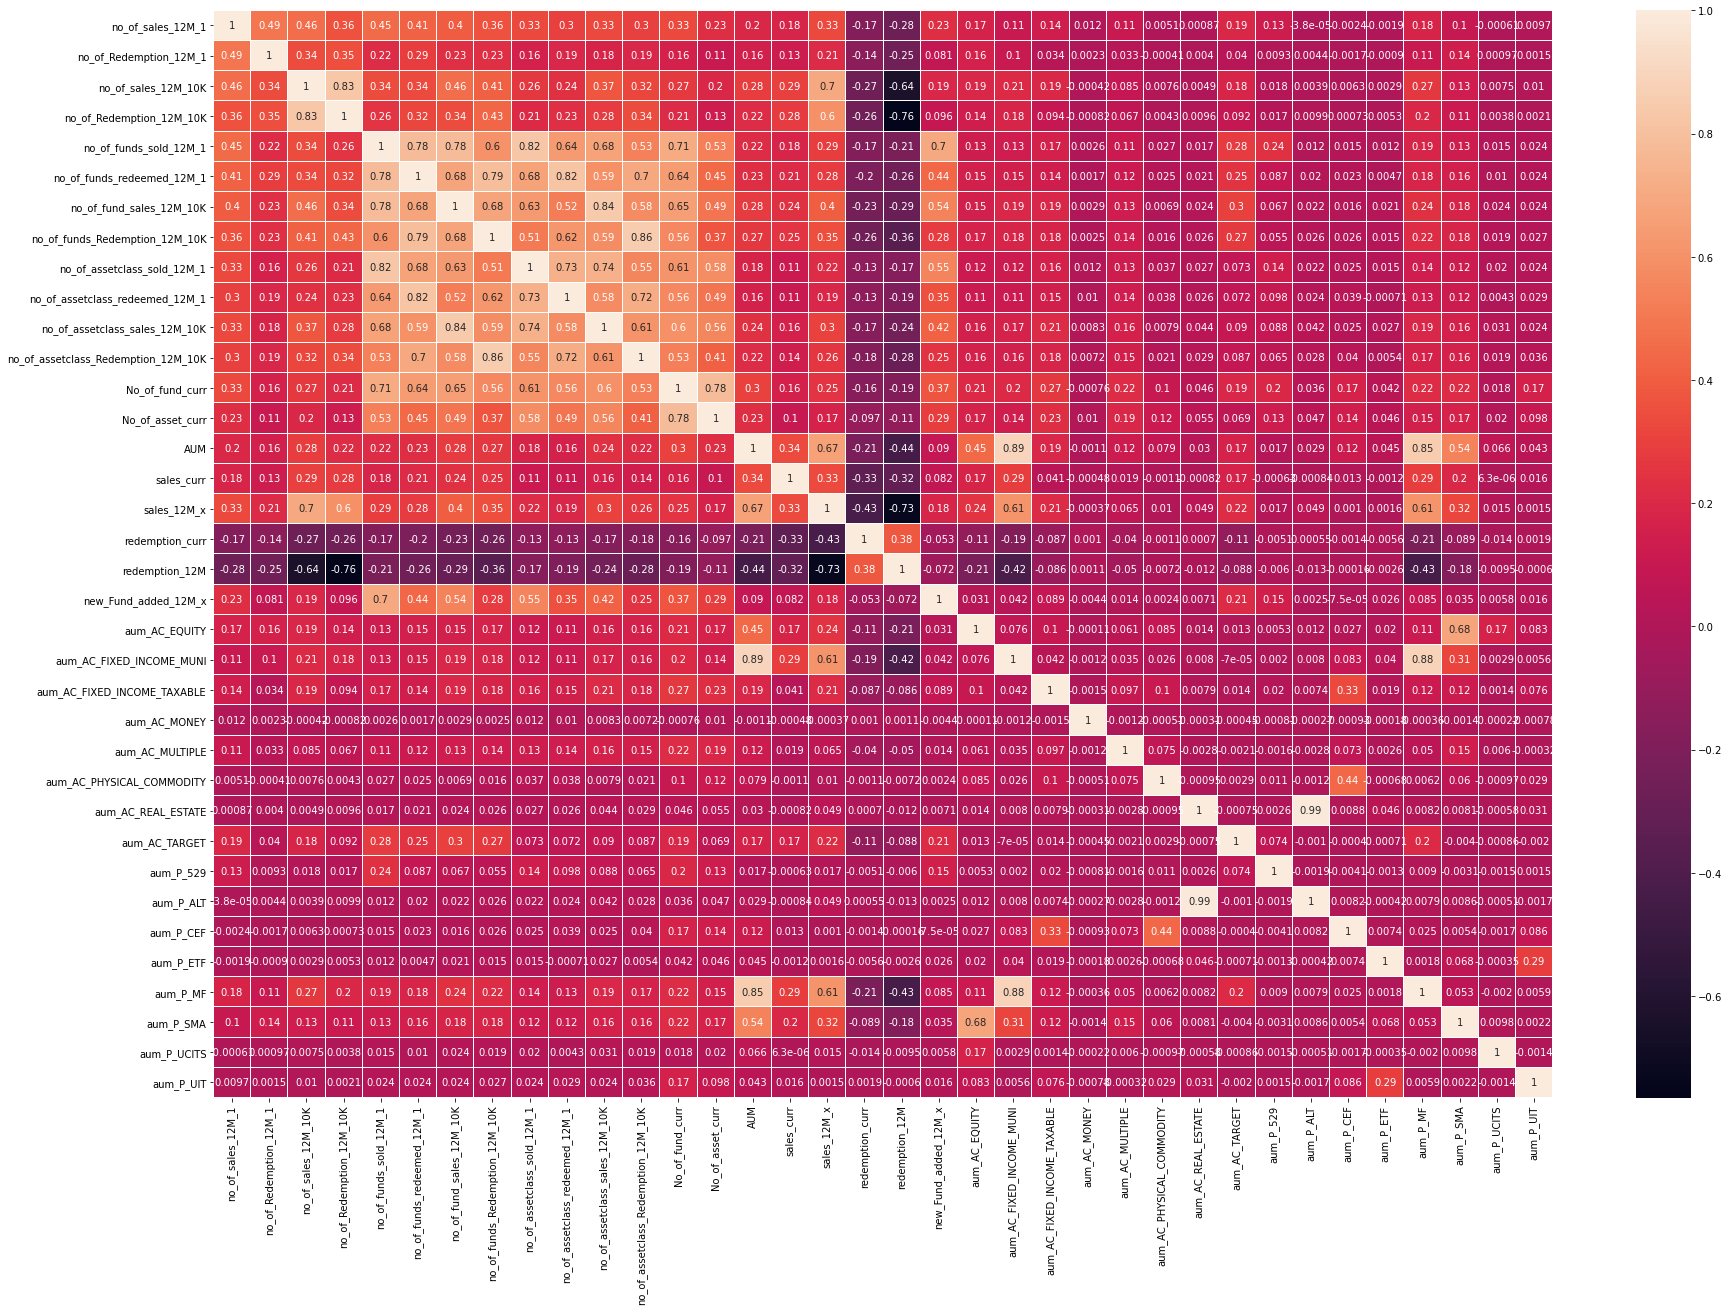

In [10]:
#Correlation map
#data.columns.values

plt.figure(figsize=(30,20))
#Compute the correlation matrix
corr=data[['no_of_sales_12M_1', 'no_of_Redemption_12M_1',
       'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
       'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
       'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
       'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
       'no_of_assetclass_sales_12M_10K',
       'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
       'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_x',
       'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_x',
       'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
       'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
       'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
       'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
       'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT']].corr()
sns.heatmap(corr,linecolor='white',linewidths=0.1,annot=True)
plt.show()

In [11]:
#%%Exploratory Data Analysis (EDA)
# data.head(10)
# X1='sales_12M_x'
# X2='sales_curr'
# X3='redemption_curr'
# data[[X1,X2,X3]].describe()
# data.hist()
# plt.close('all')

<h2>Regression</h2>

<h3>Plotting</h3>

<h4>Step 1 -> working with notnull y's</h4>

In [ ]:
#%%Linear Regression to predict sales_12M_y
#Arranging X and y
#focusing on notnull y values.  model will be fit on notnull values.  null values will be predicted.
data_reg=data[data['sales_12M_y'].notnull()]
# data_reg.info()
data_reg_predict=data[data['sales_12M_y'].isnull()]
print('Shape of data_reg: {}'.format(data_reg.shape))
print('Shape of data_reg_predict: {}'.format(data_reg_predict.shape))



In [ ]:
data_reg.describe()

In [ ]:
# #Removing a few rows that have high inputs
# indexToRemove=data_reg[(data_reg['sales_12M_x']>2e7) | (data_reg['AUM']>4e7)].index
# data_reg.drop(index=indexToRemove,inplace=True)
# data_reg.reset_index(drop=True,inplace=True)

In [ ]:
#Plotting Xs vs y
def plot_compare(x,y):
    plt.figure()
    plt.scatter(x,y)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.show()
    return None

In [ ]:
# Xs=['no_of_sales_12M_1', 'no_of_Redemption_12M_1','no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
#     'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
#     'No_of_fund_curr','No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_x',
#     'redemption_curr', 'redemption_12M']
Xs=['no_of_sales_12M_1', 'no_of_Redemption_12M_1',
       'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
       'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
       'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
       'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
       'no_of_assetclass_sales_12M_10K',
       'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
       'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_x',
       'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_x',
       'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
       'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
       'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
       'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
       'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT']
for x1 in Xs:
    plot_compare(data_reg[x1],data_reg['sales_12M_y'])


In [12]:
#Set Xs
Xs=['no_of_sales_12M_1', 'no_of_Redemption_12M_1',
'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
'No_of_fund_curr','AUM', 'sales_curr', 'sales_12M_x',
'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_x',
'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI']

In [ ]:
data_reg['sales_12M_y'].median()

In [ ]:
# sns.pairplot(data_reg[['no_of_sales_12M_1', 'no_of_Redemption_12M_1',
#        'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
#        'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
#        'No_of_fund_curr','No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_x',
#        'redemption_curr', 'redemption_12M','sales_12M_y']])
# plt.show()

In [ ]:
#Correlation map of data_reg
#data.columns.values

plt.figure(figsize=(30,20))
#Compute the correlation matrix
corr=data_reg[Xs].corr()
sns.heatmap(corr,linecolor='white',linewidths=0.1,annot=True)
plt.show()

In [ ]:
#Plotting histogram of some Xs
def plot_histBox(data1,name1,data2,name2):
    '''
    Inputs:
    data1: data series 1 to plot
    name1: name of data series 1
    data2: data series 2 to plot
    name2: name of data series 2
    
    Output:
    plots of histogram and boxplot
    '''
    
    fig, (ax1,ax2)=plt.subplots(1,2)
    ax1.hist(data1)
    ax2.boxplot(data1,showbox=True)
    fig.suptitle(name1)
    plt.show()
    fig, (ax3,ax4)=plt.subplots(1,2)
    ax3.hist(data2)
    ax4.boxplot(data2,showbox=True)
    fig.suptitle(name2)
    plt.show()
    return None

In [ ]:
#Calculating Q3+1.5*IQR
def calc_uppLimit(data1,name1):
    '''
    Input: data series,name1
    Output: upper limit to remove outliers
    '''
    print('Std of '+name1+': {}'.format(data1.std()))
    print('3rd quartile of '+name1+': {}'.format(data1.quantile(0.75)))
    limit=data1.quantile(0.75)+1.5*(data1.quantile(0.75)-data1.quantile(0.25))
    print('Upper limit in '+name1+' to remove outliers: {}'.format(limit))
    return limit

In [ ]:
#plot_histBox(data_reg[X1],X1,data_reg[X2],X2)

In [ ]:
#limit_X1=calc_uppLimit(data_reg[X1],X1)

<h4>Step 2 -> removing outliers in sales_12M_x</h4>

In [ ]:
# data_reg2=data_reg[data_reg[X1]<=limit_X1] #removing outliers from sales_12M_x
# plot_histBox(data_reg2[X1],X1,data_reg2[X1],X1)

<h4>Step 3 -> removing outliers in sales_curr</h4>

In [ ]:
# limit_AUM=calc_uppLimit(data_reg2[X2],X2)

<h4>Step 2 -> removing outliers in sales_curr</h4>

In [ ]:
# data_reg3=data_reg2[data_reg2[X2]<=limit_AUM] #removing outliers from sales_12M_x
# plot_histBox(data_reg3[X1],X1,data_reg3[X2],X2)

In [ ]:
#Removing outliers did not help. Stick to all Xs
X=data_reg[Xs]
y=data_reg['sales_12M_y']
X_predict=data_reg_predict[Xs]

In [ ]:
X.describe()

<h2>Scaling</h2>

In [ ]:
transformer=RobustScaler()
X_transformed=transformer.fit_transform(X)

In [21]:
def plot_transformed(X,Xs):
    for i in range(X.shape[1]):
        plt.figure(figsize=(5,5))
        plt.hist(X[:,i])
        plt.xlabel(Xs[i])

    plt.tight_layout()
    plt.show()
    return None

In [ ]:
plot_transformed(X_transformed,Xs)
# for i in range(X_transformed.shape[1]):
#     plt.figure(figsize=(5,5))
#     plt.hist(X_transformed[:,i])
#     plt.xlabel(Xs[i])

# plt.tight_layout()
# plt.show()


In [ ]:
#randomly separating train and test

X_train,X_test,y_train,y_test=train_test_split(X_transformed,y,test_size=0.25)

<h4>Dummy Regressor</h4>

In [ ]:
#Dummy Regressor
dummy_regr=DummyRegressor(strategy='mean')
dummy_regr.fit(X_train,y_train)
print('R^2 of test: {}'.format(dummy_regr.score(X_test,y_test)))
print('R^2 of train: {}'.format(dummy_regr.score(X_train,y_train)))

In [ ]:
#fitting LinearRegression
linreg=linear_model.LinearRegression(normalize=True)
linreg.fit(X_train,y_train)
print('R^2 of test: {}'.format(linreg.score(X_test,y_test)))
print('R^2 of train: {}'.format(linreg.score(X_train,y_train)))


In [ ]:
yTest_predict=linreg.predict(X_test)
residuals=y_test-yTest_predict
plt.hist(residuals)
plt.show()

In [ ]:
#SUPPORT VECTOR REGRESSION
#LinearRegression is not giving good scores. Trying Support Vector Regression
kern=['linear','poly','rbf','sigmoid']
for trial in kern:
    svm_reg=SVR(kernel=trial,verbose=True)
    svm_reg.fit(X_train,y_train)
    print('Kernel of SVR: '+trial)
    print('R^2 of test: {}'.format(svm_reg.score(X_test,y_test)))
    print('R^2 of train: {}'.format(svm_reg.score(X_train,y_train)))

In [ ]:
#STOCHASTIC GRADIENT DESCENT
sgd_reg=SGDRegressor()
sgd_reg.fit(X_train,y_train)
print('R^2 of test: {}'.format(sgd_reg.score(X_test,y_test)))
print('R^2 of train: {}'.format(sgd_reg.score(X_train,y_train)))

In [ ]:
#GRADIENT BOOSTING REGRESSOR
gb_reg=GradientBoostingRegressor()
gb_reg.fit(X_train,y_train)
print('R^2 of test: {}'.format(gb_reg.score(X_test,y_test)))
print('R^2 of train: {}'.format(gb_reg.score(X_train,y_train)))

In [ ]:
#GRID_SEARCH
param_grid={'loss':['ls','lad','huber','quantile'],
           'learning_rate':[0.05,0.1,0.5],
           'max_depth':[3,4,5,6],'n_estimators':[50,100,150]}
gb_reg_GS=GridSearchCV(gb_reg,param_grid,cv=2,return_train_score=True,scoring='r2')
gb_reg_GS.fit(X_train,y_train)

In [ ]:
gb_reg_GS_results=pd.DataFrame(data=gb_reg_GS.cv_results_)

In [ ]:
gb_reg_GS_results.sort_values(by='rank_test_score',axis=0,)

In [ ]:
print('Best estimator:')
print(gb_reg_GS.best_estimator_)
print('Best score:')
print(gb_reg_GS.best_score_)
print('Best params:')
print(gb_reg_GS.best_params_)

In [ ]:
#Predict for empty y's
X_predict_transformed=transformer.fit_transform(X_predict)
y_predict=gb_reg_GS.predict(X_predict_transformed)

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.hist(y_predict)
ax1.set_title('y_predict')

ax2.hist(y)
ax2.set_title('y')

In [ ]:
X_predict.head()

In [ ]:
X_predict.index.values

In [ ]:
#Filling in empty y values with y_predict
data.loc[X_predict.index.values,'sales_12M_y']=y_predict

In [ ]:
#data.info()
data['sales_12M_y'].hist()

<h1>Classification</h1>

In [13]:
data.head()
data.tail()
data['new_Fund_added_12M_y'].describe()

count    5074.000000
mean        0.496847
std         0.500039
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: new_Fund_added_12M_y, dtype: float64

In [15]:
#Separating dataframe with labels and without labels
data_class=data[data['new_Fund_added_12M_y'].notnull()]
data_class_predict=data[data['new_Fund_added_12M_y'].isnull()]
print('Count of labeled new_Fund_added_12M_y: {}'.format(data_class.shape))
print('Count of unlabeled new_Fund_added_12M_y: {}'.format(data_class_predict.shape))

Count of labeled new_Fund_added_12M_y: (5074, 41)
Count of unlabeled new_Fund_added_12M_y: (4931, 41)


In [26]:
#creating X and Y
X_class=data_class[Xs]
y_class=data_class['new_Fund_added_12M_y']
X_class_predict=data_class_predict[Xs]

In [17]:
#transform X values
transformer=RobustScaler()
X_class_transformed=transformer.fit_transform(X_class)

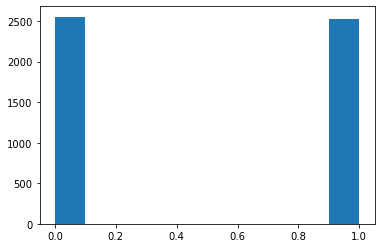

In [19]:
plt.hist(y_class);
#observing balanced classes

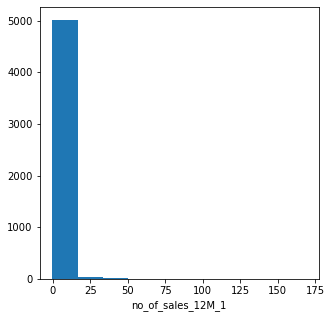

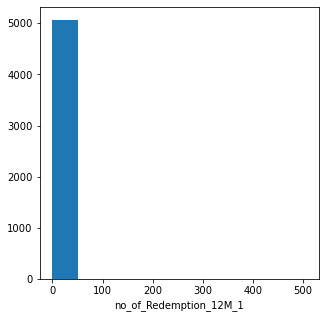

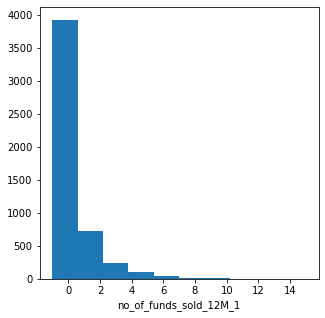

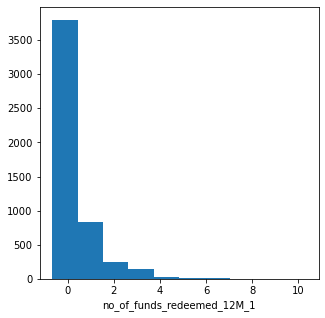

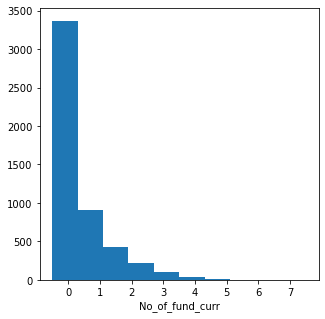

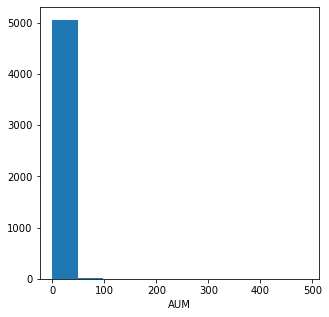

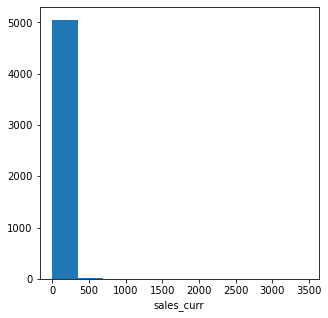

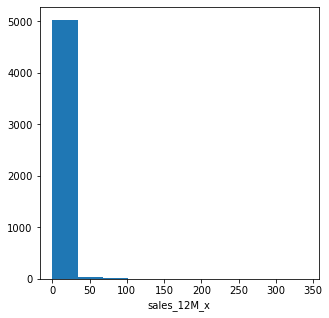

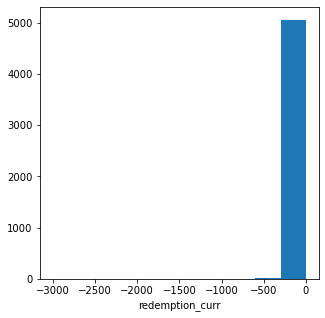

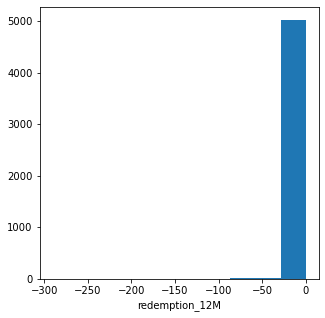

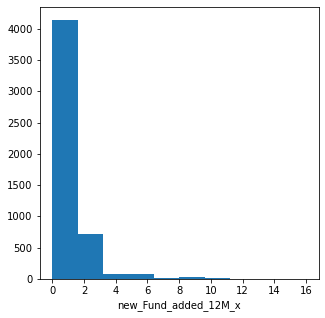

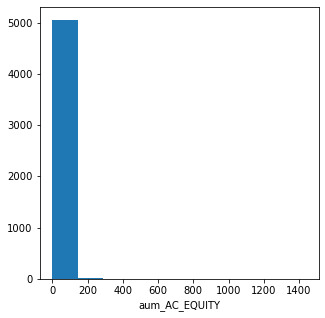

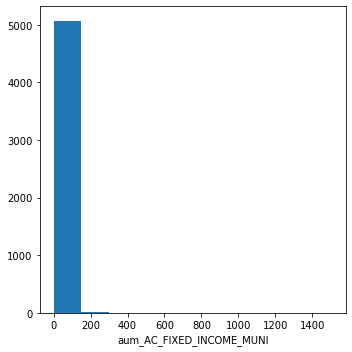

In [22]:
plot_transformed(X_class_transformed,Xs)

In [23]:
#randomly separating train and test

X_train,X_test,y_train,y_test=train_test_split(X_class_transformed,y_class,test_size=0.25,random_state=30)

In [24]:
#GRADIENT BOOSTING CLASSIFIER
gb_clf=GradientBoostingClassifier()
gb_clf.fit(X_train,y_train)
print('Mean accuracy of test: {}'.format(gb_clf.score(X_test,y_test)))
print('Mean accuracy of train: {}'.format(gb_clf.score(X_train,y_train)))

R^2 of test: 0.6721828211189913
R^2 of train: 0.7395532194480946


In [37]:
X_class_predict_transformed=transformer.fit_transform(data[Xs])
fund_2019_probs=gb_clf.predict_proba(X_class_predict_transformed)
fund_2019=gb_clf.predict(X_class_predict_transformed)

In [39]:
data['fund_2019']=fund_2019
data['fund_2019_probs']=np.max(fund_2019_probs,axis=1)

In [40]:
data.head()

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_x,redemption_curr,redemption_12M,new_Fund_added_12M_x,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_x,sales_12M_y,new_Fund_added_12M_y,refresh_date_y,fund_2019,fund_2019_probs
0,0047433,21.0,38.0,0.0,1.0,5.0,5.0,0.0,1.0,2.0,2.0,0.0,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,0.0,0.0,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105,0.0,2019-12-31,1.0,0.562806
1,4461312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19629.00,0.0,0.0,0.000,0.000,0.0,0.0,19629.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19629.00,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,0.0,0.727732
2,4491079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.0,0.0,0.000,0.000,0.0,0.0,1758.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,0.0,0.727732
3,0107408,20.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,57943.00,5459.0,52484.0,0.000,0.000,1.0,0.0,0.00,57943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57943.00,0.00,0.0,0.0,2018-12-31,93212.000,1.0,2019-12-31,1.0,0.630329
4,85101140503769936458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,0.0,0.721893
